In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
torch.manual_seed(1)

# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

print("train_dataset size:", len(train_dataset),"\ntest_dataset size:", len(test_dataset))

train_dataset size: 60000 
test_dataset size: 10000


In [3]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=600, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=100, 
                                          shuffle=False)

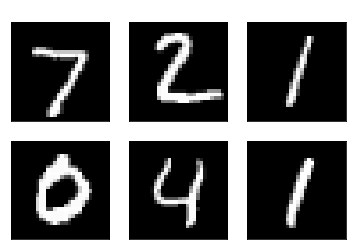

In [4]:
examples = iter(test_loader)
example_data, example_targets = examples.next()

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
    plt.title("Actual Val: {}".format(example_targets[i]),color='white')
    plt.xticks([])
    plt.yticks([])
plt.show()

In [5]:
# Hyper-parameters 
input_size = 784 # 28x28
max_epochs = 15
learning_rate = 0.001
kernel_size = 4
weight_decay_val = 1e-4
dropout = 0.25

In [6]:
class CNN1(nn.Module):
    def __init__(self,):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size) #1st Convolution
        self.pool = nn.MaxPool2d(2, 2)   #pool_size=2, strides=2 
        self.conv2 = nn.Conv2d(10, 20, kernel_size) #2nd Convolution
        self.fc1 = nn.Linear(320, 50) #((I/P - Filter + 2*Pad)/Stride)+1 
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(50, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        x = x.view(-1, 320)            #Flattening 
        x = F.relu(self.fc1(x))        #Fully Connected NN   
        x = self.dropout(x)   
        x = F.relu(self.fc2(x))        #Fully Connected NN           
        x = self.fc3(x)                #O/P Layer       
        return x

In [7]:
cnn1 = CNN1()
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn1.parameters(), lr=learning_rate, weight_decay = weight_decay_val)

a=[]
for i in cnn1.parameters():
    a.append(torch.numel(i))
print('Total no of parameters in Model 1:', np.sum(a),)

Total no of parameters in Model 1: 25550


In [8]:
# train_losses = []
# train_epoch = []
# train_acc = []
# test_losses = []
# test_epoch = []
# not_converged =True
# epoch = 0
# Train the model

#for epoch in range(num_epochs):
def testFunc(model,num_epochs):
    n_total_steps = len(train_loader)
    train_losses = []
    train_epoch = []
    train_acc = []
    test_losses = []
    test_epoch = []
    not_converged =True
    epoch = 0
    while not_converged:
        epoch += 1
        n_correct = 0
        n_samples = 0
        for i, (images, labels) in enumerate(train_loader):  
            # Forward pass
            prediction = model(images)
            loss = loss_func(prediction, labels)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            acc = 100.0 * n_correct / n_samples

            if (i+1) % 100 == 0:
                print (f'Epoch [{epoch}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
                train_epoch.append(epoch)
                train_losses.append(loss.item())
                print(f'Epoch [{epoch}/{num_epochs}], Accuracy : {acc} %')
                train_acc.append(acc)

                if epoch == num_epochs:
                        print("Max Epoch Reached")
                        not_converged = False
                elif (epoch > 5) and  (train_losses[-1] < 0.001):
                    if abs(train_losses[-3] - train_losses[-2]) < 1.0e-05 and abs(train_losses[-2] - train_losses[-1]) < 1.0e-05:
                        print("Convergeance reached for loss:",train_losses[-1])
                        not_converged = False
                        
    return train_epoch,train_losses,train_acc

In [9]:
train_epoch,train_losses,train_acc=testFunc(cnn1,max_epochs)

Epoch [1/15], Step [100/100], Loss: 0.3931
Epoch [1/15], Accuracy : 68.07333333333334 %
Epoch [2/15], Step [100/100], Loss: 0.2127
Epoch [2/15], Accuracy : 90.495 %


KeyboardInterrupt: 

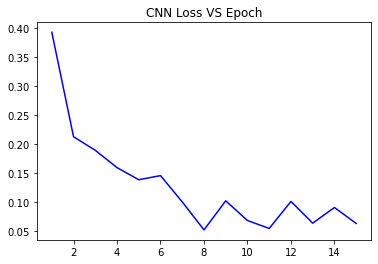

In [ ]:
#plot
plt.plot(train_epoch,train_losses,color="blue")
plt.title('CNN Loss VS Epoch')
plt.show()

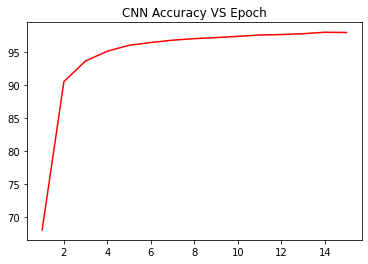

In [ ]:
#plot
plt.plot(train_epoch,train_acc,color="red")
plt.title('CNN Accuracy VS Epoch')
plt.show()

In [ ]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for test_images, test_labels in test_loader:
        outputs = cnn1(test_images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += test_labels.size(0)
        n_correct += (predicted == test_labels).sum().item()
        
        for i in range(100):
            label = test_labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    netTest_acc1 = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {netTest_acc1} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {i}: {acc} %')

Accuracy of the network: 97.94 %
Accuracy of 0: 98.57142857142857 %
Accuracy of 1: 98.94273127753304 %
Accuracy of 2: 98.93410852713178 %
Accuracy of 3: 96.93069306930693 %
Accuracy of 4: 98.98167006109979 %
Accuracy of 5: 98.65470852017937 %
Accuracy of 6: 97.49478079331942 %
Accuracy of 7: 97.08171206225681 %
Accuracy of 8: 96.09856262833675 %
Accuracy of 9: 97.62140733399406 %


In [ ]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        prediction = cnn1(images)
        # max returns (value ,index)
        _, predicted = torch.max(prediction.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    netTest_acc1 = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the test images: {netTest_acc1} %')

Accuracy of the network on the test images: 97.93 %


In [10]:
class CNN2(nn.Module):
    def __init__(self,):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size) #1st Convolution
        self.pool = nn.MaxPool2d(2, 2)   #pool_size=2, strides=2 
        self.conv2 = nn.Conv2d(10, 20, kernel_size) #2nd Convolution
        self.fc1 = nn.Linear(20*kernel_size*kernel_size, 50) #((I/P - Filter + 2*Pad)/Stride)+1 
        self.fc2 = nn.Linear(50,50)
        self.fc3 = nn.Linear(50,40)
        self.fc4 = nn.Linear(40,30)
        self.fc5 = nn.Linear(30, 10)

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        x = x.view(-1, 320)            #Flattening 
        x = F.relu(self.fc1(x))        #Fully Connected NN       
        x = F.relu(self.fc2(x))        #Fully Connected NN 
        x = F.relu(self.fc3(x))        #Fully Connected NN 
        x = F.relu(self.fc4(x))        #Fully Connected NN
        #x = F.relu(self.fc5(x))        #Fully Connected NN 
        x = self.fc5(x)                #O/P Layer       
        return x


In [11]:
cnn2 = CNN2()
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn2.parameters(), lr=learning_rate, weight_decay = weight_decay_val)

a=[]

for i in cnn2.parameters():
    a.append(torch.numel(i))
print('Total no of parameters in Model 2:', np.sum(a),)

Total no of parameters in Model 2: 25570


In [13]:
train_epoch2,train_losses2,train_acc2=testFunc(cnn2,max_epochs)

Epoch [1/15], Step [100/100], Loss: 0.3905
Epoch [1/15], Accuracy : 82.36166666666666 %


KeyboardInterrupt: 

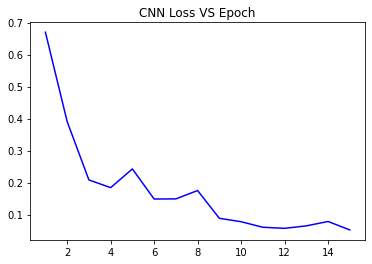

In [ ]:
#plot
plt.plot(train_epoch2,train_losses2,color="blue")
plt.title('CNN Loss VS Epoch')
plt.show()

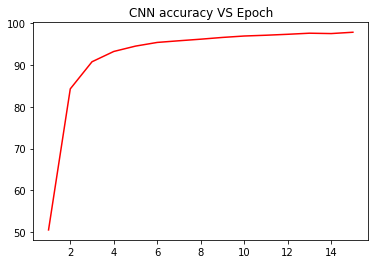

In [ ]:
#plot
plt.plot(train_epoch2,train_acc2,color="red")
plt.title('CNN accuracy VS Epoch')
plt.show()

In [ ]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for test_images, test_labels in test_loader:
        outputs = cnn2(test_images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += test_labels.size(0)
        n_correct += (predicted == test_labels).sum().item()
        
        for i in range(100):
            label = test_labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    netTest_acc2 = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {netTest_acc2} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {i}: {acc} %')

Accuracy of the network: 98.18 %
Accuracy of 0: 99.28571428571429 %
Accuracy of 1: 99.47136563876651 %
Accuracy of 2: 96.89922480620154 %
Accuracy of 3: 98.31683168316832 %
Accuracy of 4: 99.38900203665987 %
Accuracy of 5: 97.30941704035874 %
Accuracy of 6: 98.32985386221294 %
Accuracy of 7: 98.15175097276264 %
Accuracy of 8: 97.3305954825462 %
Accuracy of 9: 97.12586719524282 %


In [ ]:
#Model 3
class CNN3(nn.Module):
    def __init__(self,): 
        super(CNN3, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 15, 5)
        #self.conv3 =  nn.Conv2d(16,32,5)
        self.fc1 = nn.Linear(15*4*4, 86)
        self.fc2 = nn.Linear(86, 10)
        #self.fc3 = nn.Linear(l2, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #x = self.pool(F.relu(self.conv3(x)))
        #print(x.shape)
        x = x.view(-1, 15*4*4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        # x = F.relu(self.fc2(x))
        # x = self.fc3(x)
        return x

In [ ]:
cnn3 = CNN3()
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn3.parameters(), lr=learning_rate, weight_decay = weight_decay_val)

a=[]

for i in cnn3.parameters():
    a.append(torch.numel(i))
print('Total no of parameters in Model 3:', np.sum(a))

Total no of parameters in Model 3: 25621


In [ ]:
train_epoch3,train_losses3,train_acc3=testFunc(cnn3,max_epochs)

Epoch [1/15], Step [100/100], Loss: 0.2840
Epoch [1/15], Accuracy : 76.73166666666667 %
Epoch [2/15], Step [100/100], Loss: 0.1750
Epoch [2/15], Accuracy : 93.75166666666667 %
Epoch [3/15], Step [100/100], Loss: 0.1205
Epoch [3/15], Accuracy : 96.02666666666667 %
Epoch [4/15], Step [100/100], Loss: 0.0755
Epoch [4/15], Accuracy : 96.94 %
Epoch [5/15], Step [100/100], Loss: 0.0926
Epoch [5/15], Accuracy : 97.47333333333333 %
Epoch [6/15], Step [100/100], Loss: 0.0549
Epoch [6/15], Accuracy : 97.91833333333334 %
Epoch [7/15], Step [100/100], Loss: 0.0638
Epoch [7/15], Accuracy : 98.03 %
Epoch [8/15], Step [100/100], Loss: 0.0569
Epoch [8/15], Accuracy : 98.24 %
Epoch [9/15], Step [100/100], Loss: 0.0451
Epoch [9/15], Accuracy : 98.44 %
Epoch [10/15], Step [100/100], Loss: 0.0573
Epoch [10/15], Accuracy : 98.57666666666667 %
Epoch [11/15], Step [100/100], Loss: 0.0667
Epoch [11/15], Accuracy : 98.67833333333333 %
Epoch [12/15], Step [100/100], Loss: 0.0478
Epoch [12/15], Accuracy : 98.748

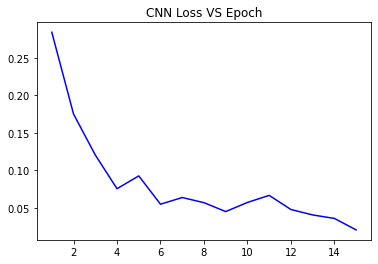

In [ ]:
#plot
plt.plot(train_epoch3,train_losses3,color="blue")
plt.title('CNN Loss VS Epoch')
plt.show()

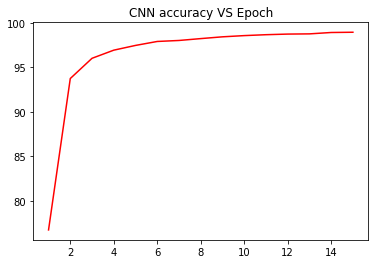

In [ ]:
#plot
plt.plot(train_epoch3,train_acc3,color="red")
plt.title('CNN accuracy VS Epoch')
plt.show()

In [ ]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for test_images, test_labels in test_loader:
        outputs = cnn3(test_images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += test_labels.size(0)
        n_correct += (predicted == test_labels).sum().item()
        
        for i in range(100):
            label = test_labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    netTest_acc3 = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {netTest_acc3} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {i}: {acc} %')

Accuracy of the network: 98.88 %
Accuracy of 0: 99.48979591836735 %
Accuracy of 1: 99.8237885462555 %
Accuracy of 2: 98.93410852713178 %
Accuracy of 3: 99.3069306930693 %
Accuracy of 4: 98.98167006109979 %
Accuracy of 5: 98.09417040358744 %
Accuracy of 6: 98.53862212943632 %
Accuracy of 7: 97.47081712062257 %
Accuracy of 8: 98.76796714579055 %
Accuracy of 9: 99.20713577799802 %


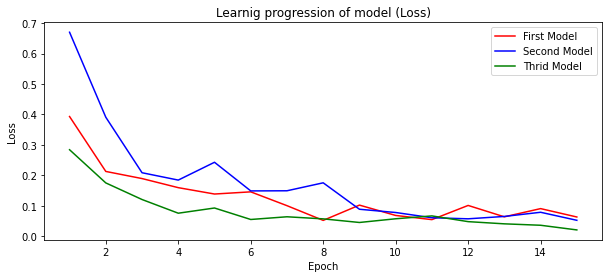

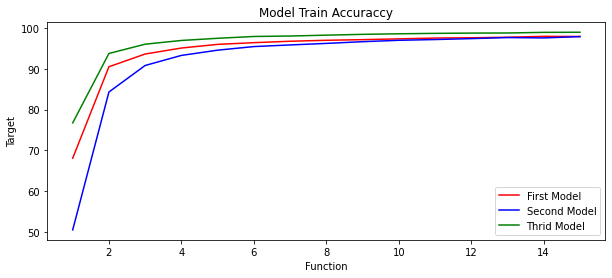

CNN1 Test Accuracy: 97.93 % 
CNN2 Test Accuracy: 98.18 % 
CNN3 Test Accuracy: 98.88 %


In [ ]:
plt.figure(figsize=(10,4))
plt.plot(train_epoch,train_losses, color = "red")
plt.plot(train_epoch2,train_losses2, color = "blue")
plt.plot(train_epoch3,train_losses3, color = "green")
plt.title('Learnig progression of model (Loss)')
plt.legend(['First Model', 'Second Model','Thrid Model'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('EpochVSLoss.png')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(train_epoch,train_acc,color="red")
plt.plot(train_epoch2,train_acc2,color="blue")
plt.plot(train_epoch3,train_acc3,color="green")
plt.title('Model Train Accuraccy')
plt.legend(['First Model', 'Second Model','Thrid Model'])
plt.xlabel('Function')
plt.ylabel('Target')
plt.savefig('Model_Prediction.png')
plt.show()

print('CNN1 Test Accuracy:',netTest_acc1,'%','\nCNN2 Test Accuracy:',netTest_acc2,'%','\nCNN3 Test Accuracy:',netTest_acc3,'%')

In [ ]:
##Skorch Optimization##
import skorch
from skorch import NeuralNetClassifier
import sklearn
from sklearn.model_selection import GridSearchCV



In [ ]:
net = NeuralNetClassifier(
    CNN3,
    max_epochs=15,
    lr=0.1,
    #loss_function= torch.nn.CrossEntropyLoss(),
    optimizer = torch.optim.Adam,
    #device=device,
)

params = {
    'lr': [0.01,0.015, 0.02,0.001],
    'max_epochs': [5, 10, 15],
    'optimizer': [torch.optim.Adam, torch.optim.RMSprop,torch.optim.SGD ],
    #'loss_function': [torch.nn.CrossEntropyLoss(),torch.nn.MSELoss()]
}

In [ ]:
# for i, (images, labels) in enumerate(train_loader): 
#     net.fit(images, labels)


gs = GridSearchCV(net, params, refit=False, cv=3, scoring='accuracy')

gs.fit(images, labels)
print(gs.best_score_, gs.best_params_)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0130
      2           nan       0.0714           nan  0.0100
      3           nan       0.0714           nan  0.0120
      4           nan       0.0714           nan  0.0100
      5           nan       0.0714           nan  0.0100
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0100
      2           nan       0.0714           nan  0.0140
      3           nan       0.0714           nan  0.0140
      4           nan       0.0714           nan  0.0130
      5           nan       0.0714           nan  0.0100
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0110
      2           nan       0.1

E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


      3           nan       0.0714           nan  0.0110
      4           nan       0.2143           nan  0.0110
      5           nan       0.1429           nan  0.0120
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0090
      2           nan       0.0714           nan  0.0120
      3           nan       0.0714           nan  0.0120
      4           nan       0.0714           nan  0.0100
      5           nan       0.0714           nan  0.0120
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.1429           nan  0.0110
      2           nan       0.0714           nan  0.0110
      3           nan       0.0714           nan  0.0100
      4           nan       0.0714           nan  0.0110
      5           nan       0.0714           nan  0.0110
  epoch    train_loss    valid_

E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


      5           nan       0.1429           nan  0.0110
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.1429           nan  0.0090
      2           nan       0.0714           nan  0.0110
      3           nan       0.0714           nan  0.0110
      4           nan       0.0714           nan  0.0110
      5           nan       0.0714           nan  0.0100
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0110
      2           nan       0.0714           nan  0.0120
      3           nan       0.0714           nan  0.0110
      4           nan       0.0714           nan  0.0110
      5           nan       0.0714           nan  0.0120
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.1

E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


      5           nan       0.1429           nan  0.0110
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.1429           nan  0.0110
      2           nan       0.0714           nan  0.0130
      3           nan       0.0714           nan  0.0110
      4           nan       0.1429           nan  0.0110
      5           nan       0.0714           nan  0.0110
      6           nan       0.0714           nan  0.0110
      7           nan       0.0714           nan  0.0120
      8           nan       0.0714           nan  0.0120
      9           nan       0.0714           nan  0.0100
     10           nan       0.0714           nan  0.0120
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.1429           nan  0.0100
      2           nan       0.1429           nan  0.0120
      3           nan       0.1

E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


      4           nan       0.1429           nan  0.0110
      5           nan       0.1429           nan  0.0120
      6           nan       0.1429           nan  0.0120
      7           nan       0.1429           nan  0.0120
      8           nan       0.1429           nan  0.0113
      9           nan       0.1429           nan  0.0110
     10           nan       0.1429           nan  0.0120
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.1429           nan  0.0100
      2           nan       0.1429           nan  0.0110
      3           nan       0.1429           nan  0.0120
      4           nan       0.1429           nan  0.0100
      5           nan       0.1429           nan  0.0120
      6           nan       0.1429           nan  0.0120
      7           nan       0.1429           nan  0.0110
      8           nan       0.1429           nan  0.0120
      9           nan       0.1

E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


      5           nan       0.0714           nan  0.0110
      6           nan       0.0714           nan  0.0100
      7           nan       0.0714           nan  0.0110
      8           nan       0.0714           nan  0.0130
      9           nan       0.0714           nan  0.0120
     10           nan       0.0714           nan  0.0120
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.1429           nan  0.0110
      2           nan       0.0714           nan  0.0120
      3           nan       0.0714           nan  0.0120
      4           nan       0.0714           nan  0.0110
      5           nan       0.0714           nan  0.0110
      6           nan       0.0714           nan  0.0100
      7           nan       0.0714           nan  0.0120
      8           nan       0.0714           nan  0.0120
      9           nan       0.0714           nan  0.0120
     10           nan       0.0

E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


      4           nan       0.1429           nan  0.0120
      5           nan       0.1429           nan  0.0110
      6           nan       0.1429           nan  0.0111
      7           nan       0.1429           nan  0.0110
      8           nan       0.1429           nan  0.0110
      9           nan       0.1429           nan  0.0110
     10           nan       0.1429           nan  0.0120
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0100
      2           nan       0.0714           nan  0.0110
      3           nan       0.0714           nan  0.0120
      4           nan       0.0000           nan  0.0110
      5           nan       0.0000           nan  0.0110
      6           nan       0.0000           nan  0.0110
      7           nan       0.0000           nan  0.0120
      8           nan       0.0000           nan  0.0120
      9           nan       0.0

E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


      6           nan       0.0714           nan  0.0100
      7           nan       0.0000           nan  0.0120
      8           nan       0.0000           nan  0.0110
      9           nan       0.0000           nan  0.0120
     10           nan       0.0000           nan  0.0120
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0110
      2           nan       0.0714           nan  0.0130
      3           nan       0.0714           nan  0.0120
      4           nan       0.0714           nan  0.0110
      5           nan       0.1429           nan  0.0120
      6           nan       0.1429           nan  0.0100
      7           nan       0.0714           nan  0.0110
      8           nan       0.0714           nan  0.0100
      9           nan       0.0714           nan  0.0110
     10           nan       0.0714           nan  0.0110
  epoch    train_loss    valid_

E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


      5           nan       0.0714           nan  0.0120
      6           nan       0.0714           nan  0.0110
      7           nan       0.0714           nan  0.0110
      8           nan       0.0714           nan  0.0130
      9           nan       0.0714           nan  0.0120
     10           nan       0.0714           nan  0.0120
     11           nan       0.0714           nan  0.0110
     12           nan       0.0714           nan  0.0120
     13           nan       0.0714           nan  0.0123
     14           nan       0.0714           nan  0.0120
     15           nan       0.0714           nan  0.0113
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0100
      2           nan       0.0714           nan  0.0120
      3           nan       0.0714           nan  0.0120
      4           nan       0.0714           nan  0.0120
      5           nan       0.0

E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


     13           nan       0.0714           nan  0.0620
     14           nan       0.0714           nan  0.0160
     15           nan       0.0714           nan  0.0160
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0140
      2           nan       0.0714           nan  0.0152
      3           nan       0.0714           nan  0.0130
      4           nan       0.0714           nan  0.0140
      5           nan       0.0714           nan  0.0150
      6           nan       0.0714           nan  0.0170
      7           nan       0.0714           nan  0.0160
      8           nan       0.0714           nan  0.0150
      9           nan       0.1429           nan  0.0120
     10           nan       0.1429           nan  0.0130
     11           nan       0.1429           nan  0.0120


E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


     12           nan       0.1429           nan  0.0120
     13           nan       0.1429           nan  0.0110
     14           nan       0.1429           nan  0.0140
     15           nan       0.1429           nan  0.0120
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0110
      2           nan       0.0714           nan  0.0120
      3           nan       0.0714           nan  0.0120
      4           nan       0.0714           nan  0.0120
      5           nan       0.0714           nan  0.0120
      6           nan       0.0714           nan  0.0120
      7           nan       0.0714           nan  0.0110
      8           nan       0.0714           nan  0.0100
      9           nan       0.0714           nan  0.0120
     10           nan       0.0714           nan  0.0120
     11           nan       0.0714           nan  0.0120
     12           nan       0.0

E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.1429           nan  0.0100
      2           nan       0.1429           nan  0.0130
      3           nan       0.1429           nan  0.0110
      4           nan       0.1429           nan  0.0120
      5           nan       0.0714           nan  0.0120
      6           nan       0.0714           nan  0.0120
      7           nan       0.0714           nan  0.0120
      8           nan       0.0714           nan  0.0110
      9           nan       0.0714           nan  0.0120
     10           nan       0.0714           nan  0.0123
     11           nan       0.0714           nan  0.0120
     12           nan       0.0714           nan  0.0130
     13           nan       0.0714           nan  0.0110


E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


     14           nan       0.0714           nan  0.0130
     15           nan       0.0714           nan  0.0150
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0120
      2           nan       0.1429           nan  0.0130
      3           nan       0.1429           nan  0.0130
      4           nan       0.1429           nan  0.0123
      5           nan       0.1429           nan  0.0120
      6           nan       0.1429           nan  0.0110
      7           nan       0.1429           nan  0.0120
      8           nan       0.1429           nan  0.0110
      9           nan       0.1429           nan  0.0130
     10           nan       0.1429           nan  0.0113
     11           nan       0.1429           nan  0.0120
     12           nan       0.1429           nan  0.0114
     13           nan       0.1429           nan  0.0100
     14           nan       0.1

E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


     15           nan       0.1429           nan  0.0110
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.1429           nan  0.0110
      2           nan       0.1429           nan  0.0120
      3           nan       0.1429           nan  0.0130
      4           nan       0.1429           nan  0.0120
      5           nan       0.1429           nan  0.0120
      6           nan       0.1429           nan  0.0110
      7           nan       0.1429           nan  0.0113
      8           nan       0.1429           nan  0.0120
      9           nan       0.1429           nan  0.0120
     10           nan       0.1429           nan  0.0110
     11           nan       0.1429           nan  0.0120
     12           nan       0.1429           nan  0.0110
     13           nan       0.1429           nan  0.0130
     14           nan       0.1429           nan  0.0110


E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


     15           nan       0.1429           nan  0.0110
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.2143           nan  0.0130
      2           nan       0.2143           nan  0.0110
      3           nan       0.2143           nan  0.0110
      4           nan       0.2143           nan  0.0130
      5           nan       0.1429           nan  0.0120
      6           nan       0.1429           nan  0.0110
      7           nan       0.1429           nan  0.0120
      8           nan       0.1429           nan  0.0120
      9           nan       0.1429           nan  0.0110
     10           nan       0.1429           nan  0.0120
     11           nan       0.1429           nan  0.0130
     12           nan       0.1429           nan  0.0120
     13           nan       0.1429           nan  0.0120
     14           nan       0.1429           nan  0.0120


E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


     15           nan       0.1429           nan  0.0110
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.1429           nan  0.0100
      2           nan       0.1429           nan  0.0130
      3           nan       0.0714           nan  0.0130
      4           nan       0.0714           nan  0.0124
      5           nan       0.0714           nan  0.0110
      6           nan       0.0714           nan  0.0100
      7           nan       0.0714           nan  0.0140
      8           nan       0.0714           nan  0.0130
      9           nan       0.0714           nan  0.0130
     10           nan       0.0714           nan  0.0110
     11           nan       0.0714           nan  0.0130
     12           nan       0.0714           nan  0.0110
     13           nan       0.0714           nan  0.0130


E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


     14           nan       0.0714           nan  0.0130
     15           nan       0.0714           nan  0.0120
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.1429           nan  0.0130
      2           nan       0.1429           nan  0.0120
      3           nan       0.1429           nan  0.0120
      4           nan       0.1429           nan  0.0130
      5           nan       0.1429           nan  0.0120
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0100
      2           nan       0.0714           nan  0.0110
      3           nan       0.0714           nan  0.0120
      4           nan       0.1429           nan  0.0150
      5           nan       0.0714           nan  0.0140
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  --------

E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


      3           nan       0.2143           nan  0.0130
      4           nan       0.0714           nan  0.0143
      5           nan       0.0714           nan  0.0130
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0120
      2           nan       0.0714           nan  0.0110
      3           nan       0.0714           nan  0.0120
      4           nan       0.1429           nan  0.0110
      5           nan       0.0714           nan  0.0130
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0120
      2           nan       0.1429           nan  0.0112
      3           nan       0.1429           nan  0.0120
      4           nan       0.1429           nan  0.0150
      5           nan       0.1429           nan  0.0120
  epoch    train_loss    valid_

E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


      3           nan       0.1429           nan  0.0120
      4           nan       0.1429           nan  0.0140
      5           nan       0.1429           nan  0.0570
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0160
      2           nan       0.0714           nan  0.0130
      3           nan       0.0714           nan  0.0160
      4           nan       0.0714           nan  0.0130
      5           nan       0.0714           nan  0.0130
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0120
      2           nan       0.0714           nan  0.0160
      3           nan       0.0714           nan  0.0150
      4           nan       0.0714           nan  0.0150
      5           nan       0.0714           nan  0.0140


E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0150
      2           nan       0.0714           nan  0.0130
      3           nan       0.0714           nan  0.0130
      4           nan       0.0714           nan  0.0110
      5           nan       0.0714           nan  0.0150
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.1429           nan  0.0110
      2           nan       0.1429           nan  0.0140
      3           nan       0.1429           nan  0.0120
      4           nan       0.1429           nan  0.0110
      5           nan       0.1429           nan  0.0130
      6           nan       0.1429           nan  0.0130
      7           nan       0.1429           nan  0.0120
      8           nan       0.1429           nan  0.0140
      9           nan       0.1

E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


      3           nan       0.1429           nan  0.0140
      4           nan       0.1429           nan  0.0140
      5           nan       0.1429           nan  0.0130
      6           nan       0.2143           nan  0.0130
      7           nan       0.0714           nan  0.0120
      8           nan       0.0714           nan  0.0140
      9           nan       0.0714           nan  0.0120
     10           nan       0.0714           nan  0.0122
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0100
      2           nan       0.0714           nan  0.0130
      3           nan       0.0714           nan  0.0120
      4           nan       0.0714           nan  0.0130
      5           nan       0.0714           nan  0.0140
      6           nan       0.0714           nan  0.0140
      7           nan       0.0714           nan  0.0120
      8           nan       0.0

E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


      4           nan       0.0714           nan  0.0140
      5           nan       0.0714           nan  0.0130
      6           nan       0.0714           nan  0.0120
      7           nan       0.0714           nan  0.0130
      8           nan       0.0714           nan  0.0120
      9           nan       0.0714           nan  0.0120
     10           nan       0.0714           nan  0.0110
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0130
      2           nan       0.0714           nan  0.0120
      3           nan       0.0714           nan  0.0130
      4           nan       0.0714           nan  0.0120
      5           nan       0.0714           nan  0.0150
      6           nan       0.0714           nan  0.0120
      7           nan       0.0714           nan  0.0130
      8           nan       0.0714           nan  0.0120
      9           nan       0.0

E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


      3           nan       0.0714           nan  0.0140
      4           nan       0.0714           nan  0.0140
      5           nan       0.0714           nan  0.0150
      6           nan       0.0714           nan  0.0140
      7           nan       0.0714           nan  0.0130
      8           nan       0.0714           nan  0.0130
      9           nan       0.0714           nan  0.0120
     10           nan       0.0714           nan  0.0130
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.1429           nan  0.0090
      2           nan       0.1429           nan  0.0140
      3           nan       0.1429           nan  0.0130
      4           nan       0.1429           nan  0.0130
      5           nan       0.1429           nan  0.0130
      6           nan       0.1429           nan  0.0120
      7           nan       0.1429           nan  0.0110
      8           nan       0.1

E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


      3           nan       0.0714           nan  0.0130
      4           nan       0.0714           nan  0.0143
      5           nan       0.0714           nan  0.0140
      6           nan       0.0714           nan  0.0140
      7           nan       0.0000           nan  0.0120
      8           nan       0.0714           nan  0.0130
      9           nan       0.0714           nan  0.0130
     10           nan       0.0714           nan  0.0120
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0130
      2           nan       0.0714           nan  0.0110
      3           nan       0.2857           nan  0.0120
      4           nan       0.2143           nan  0.0120
      5           nan       0.2143           nan  0.0130
      6           nan       0.2143           nan  0.0130
      7           nan       0.2143           nan  0.0120
      8           nan       0.2

E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


      4           nan       0.0714           nan  0.0150
      5           nan       0.0714           nan  0.0140
      6           nan       0.0714           nan  0.0140
      7           nan       0.0714           nan  0.0140
      8           nan       0.0714           nan  0.0140
      9           nan       0.0714           nan  0.0130
     10           nan       0.0714           nan  0.0140
     11           nan       0.0714           nan  0.0130
     12           nan       0.0714           nan  0.0150
     13           nan       0.0714           nan  0.0130
     14           nan       0.0714           nan  0.0130
     15           nan       0.0714           nan  0.0150
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.2143           nan  0.0140
      2           nan       0.2143           nan  0.0110
      3           nan       0.2143           nan  0.0130
      4           nan       0.0

E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


     13           nan       0.1429           nan  0.0160
     14           nan       0.1429           nan  0.0150
     15           nan       0.1429           nan  0.0160
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.1429           nan  0.0110
      2           nan       0.1429           nan  0.0130
      3           nan       0.1429           nan  0.0130
      4           nan       0.1429           nan  0.0130
      5           nan       0.1429           nan  0.0140
      6           nan       0.1429           nan  0.0140
      7           nan       0.0714           nan  0.0140
      8           nan       0.0714           nan  0.0140
      9           nan       0.0714           nan  0.0160
     10           nan       0.0714           nan  0.0140
     11           nan       0.0714           nan  0.0130
     12           nan       0.0714           nan  0.0130


E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


     13           nan       0.0714           nan  0.0140
     14           nan       0.0714           nan  0.0150
     15           nan       0.0714           nan  0.0150
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0130
      2           nan       0.0714           nan  0.0120
      3           nan       0.0714           nan  0.0120
      4           nan       0.0714           nan  0.0123
      5           nan       0.0714           nan  0.0130
      6           nan       0.0714           nan  0.0130
      7           nan       0.0714           nan  0.0130
      8           nan       0.0714           nan  0.0140
      9           nan       0.0714           nan  0.0130
     10           nan       0.0714           nan  0.0130
     11           nan       0.0714           nan  0.0130
     12           nan       0.0714           nan  0.0130


E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


     13           nan       0.0714           nan  0.0130
     14           nan       0.0714           nan  0.0120
     15           nan       0.0714           nan  0.0140
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.1429           nan  0.0180
      2           nan       0.1429           nan  0.0160
      3           nan       0.1429           nan  0.0150
      4           nan       0.1429           nan  0.0150
      5           nan       0.1429           nan  0.0140
      6           nan       0.1429           nan  0.0150
      7           nan       0.1429           nan  0.0130
      8           nan       0.1429           nan  0.0140
      9           nan       0.1429           nan  0.0130
     10           nan       0.1429           nan  0.0150
     11           nan       0.1429           nan  0.0150


E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


     12           nan       0.1429           nan  0.0150
     13           nan       0.1429           nan  0.0140
     14           nan       0.1429           nan  0.0140
     15           nan       0.1429           nan  0.0140
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0150
      2           nan       0.1429           nan  0.0150
      3           nan       0.1429           nan  0.0140
      4           nan       0.1429           nan  0.0150
      5           nan       0.1429           nan  0.0160
      6           nan       0.1429           nan  0.0130
      7           nan       0.1429           nan  0.0130
      8           nan       0.1429           nan  0.0160
      9           nan       0.1429           nan  0.0140
     10           nan       0.1429           nan  0.0150
     11           nan       0.1429           nan  0.0150
     12           nan       0.1

E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


     13           nan       0.1429           nan  0.0150
     14           nan       0.1429           nan  0.0150
     15           nan       0.1429           nan  0.0150
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.1429           nan  0.0160
      2           nan       0.1429           nan  0.0160
      3           nan       0.1429           nan  0.0160
      4           nan       0.1429           nan  0.0160
      5           nan       0.1429           nan  0.0160
      6           nan       0.1429           nan  0.0150
      7           nan       0.1429           nan  0.0160
      8           nan       0.1429           nan  0.0150
      9           nan       0.1429           nan  0.0160
     10           nan       0.1429           nan  0.0140


E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


     11           nan       0.1429           nan  0.0180
     12           nan       0.1429           nan  0.0140
     13           nan       0.1429           nan  0.0150
     14           nan       0.1429           nan  0.0140
     15           nan       0.1429           nan  0.0150
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0160
      2           nan       0.0714           nan  0.0140
      3           nan       0.0000           nan  0.0120
      4           nan       0.1429           nan  0.0120
      5           nan       0.1429           nan  0.0130
      6           nan       0.1429           nan  0.0160
      7           nan       0.1429           nan  0.0150
      8           nan       0.1429           nan  0.0150
      9           nan       0.1429           nan  0.0130
     10           nan       0.1429           nan  0.0160
     11           nan       0.1

E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


     13           nan       0.1429           nan  0.0150
     14           nan       0.1429           nan  0.0150
     15           nan       0.1429           nan  0.0140
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.1429           nan  0.0150
      2           nan       0.1429           nan  0.0150
      3           nan       0.1429           nan  0.0150
      4           nan       0.1429           nan  0.0150
      5           nan       0.1429           nan  0.0150
      6           nan       0.1429           nan  0.0130
      7           nan       0.1429           nan  0.0130
      8           nan       0.1429           nan  0.0150
      9           nan       0.1429           nan  0.0160
     10           nan       0.1429           nan  0.0130
     11           nan       0.1429           nan  0.0150


E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


     12           nan       0.1429           nan  0.0150
     13           nan       0.1429           nan  0.0150
     14           nan       0.1429           nan  0.0140
     15           nan       0.1429           nan  0.0160
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0170
      2           nan       0.0714           nan  0.0170
      3           nan       0.0714           nan  0.0140
      4           nan       0.0714           nan  0.0150
      5           nan       0.0714           nan  0.0140
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.1429           nan  0.0160
      2           nan       0.0714           nan  0.0170
      3           nan       0.0714           nan  0.0160
      4           nan       0.0714           nan  0.0160
      5           nan       0.0

E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0160
      2           nan       0.1429           nan  0.0150
      3           nan       0.1429           nan  0.0130
      4           nan       0.1429           nan  0.0140
      5           nan       0.0714           nan  0.0160
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.1429           nan  0.0160
      2           nan       0.1429           nan  0.0160
      3           nan       0.1429           nan  0.0130
      4           nan       0.1429           nan  0.0160
      5           nan       0.1429           nan  0.0160


E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0140
      2           nan       0.0714           nan  0.0150
      3           nan       0.0714           nan  0.0130
      4           nan       0.0714           nan  0.0150
      5           nan       0.0714           nan  0.0160
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0150
      2           nan       0.0714           nan  0.0150
      3           nan       0.1429           nan  0.0130
      4           nan       0.1429           nan  0.0160
      5           nan       0.1429           nan  0.0160


E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0120
      2           nan       0.0714           nan  0.0140
      3           nan       0.1429           nan  0.0130
      4           nan       0.1429           nan  0.0140
      5           nan       0.1429           nan  0.0140
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0140
      2           nan       0.0714           nan  0.0150
      3           nan       0.0714           nan  0.0150
      4           nan       0.0714           nan  0.0160
      5           nan       0.0714           nan  0.0160


E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.1429           nan  0.0140
      2           nan       0.1429           nan  0.0150
      3           nan       0.1429           nan  0.0150
      4           nan       0.1429           nan  0.0140
      5           nan       0.1429           nan  0.0130
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.1429           nan  0.0150
      2           nan       0.1429           nan  0.0140
      3           nan       0.1429           nan  0.0140
      4           nan       0.1429           nan  0.0130
      5           nan       0.1429           nan  0.0160
      6           nan       0.1429           nan  0.0150
      7           nan       0.1429           nan  0.0150
      8           nan       0.1429           nan  0.0150
      9           nan       0.1

E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


      2           nan       0.0714           nan  0.0170
      3           nan       0.0714           nan  0.0150
      4           nan       0.0714           nan  0.0170
      5           nan       0.0714           nan  0.0150
      6           nan       0.0714           nan  0.0130
      7           nan       0.0714           nan  0.0140
      8           nan       0.0714           nan  0.0170
      9           nan       0.0714           nan  0.0130
     10           nan       0.0714           nan  0.0170
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0150
      2           nan       0.0714           nan  0.0160
      3           nan       0.0714           nan  0.0140
      4           nan       0.0714           nan  0.0140
      5           nan       0.0714           nan  0.0120
      6           nan       0.0714           nan  0.0160
      7           nan       0.0

E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


      2           nan       0.0714           nan  0.0140
      3           nan       0.0714           nan  0.0120
      4           nan       0.0714           nan  0.0130
      5           nan       0.0714           nan  0.0130
      6           nan       0.0714           nan  0.0140
      7           nan       0.0714           nan  0.0160
      8           nan       0.0714           nan  0.0140
      9           nan       0.0714           nan  0.0120
     10           nan       0.0714           nan  0.0140
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.1429           nan  0.0140
      2           nan       0.1429           nan  0.0140
      3           nan       0.1429           nan  0.0140
      4           nan       0.1429           nan  0.0160
      5           nan       0.1429           nan  0.0140
      6           nan       0.1429           nan  0.0140
      7           nan       0.1

E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


      2           nan       0.1429           nan  0.0140
      3           nan       0.1429           nan  0.0130
      4           nan       0.1429           nan  0.0140
      5           nan       0.1429           nan  0.0140
      6           nan       0.1429           nan  0.0130
      7           nan       0.1429           nan  0.0130
      8           nan       0.1429           nan  0.0130
      9           nan       0.1429           nan  0.0160
     10           nan       0.1429           nan  0.0120
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0150
      2           nan       0.0714           nan  0.0150
      3           nan       0.0714           nan  0.0130
      4           nan       0.0714           nan  0.0150
      5           nan       0.0714           nan  0.0140
      6           nan       0.0714           nan  0.0140
      7           nan       0.0

E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.1429           nan  0.0170
      2           nan       0.1429           nan  0.0140
      3           nan       0.1429           nan  0.0140
      4           nan       0.1429           nan  0.0130
      5           nan       0.1429           nan  0.0130
      6           nan       0.1429           nan  0.0120
      7           nan       0.1429           nan  0.0140
      8           nan       0.1429           nan  0.0120
      9           nan       0.1429           nan  0.0130
     10           nan       0.1429           nan  0.0140
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0130
      2           nan       0.0714           nan  0.0140
      3           nan       0.0714           nan  0.0140
      4           nan       0.0

E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


      2           nan       0.0714           nan  0.0180
      3           nan       0.0714           nan  0.0140
      4           nan       0.0714           nan  0.0140
      5           nan       0.0714           nan  0.0140
      6           nan       0.0714           nan  0.0160
      7           nan       0.0714           nan  0.0140
      8           nan       0.0714           nan  0.0150
      9           nan       0.0714           nan  0.0150
     10           nan       0.0714           nan  0.0150
     11           nan       0.0714           nan  0.0140
     12           nan       0.0714           nan  0.0150
     13           nan       0.0714           nan  0.0150
     14           nan       0.0714           nan  0.0150
     15           nan       0.0714           nan  0.0130
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.1429           nan  0.0160
      2           nan       0.1

E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


     12           nan       0.0714           nan  0.0150
     13           nan       0.0714           nan  0.0130
     14           nan       0.0714           nan  0.0140
     15           nan       0.0714           nan  0.0120
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0140
      2           nan       0.0714           nan  0.0140
      3           nan       0.0714           nan  0.0150
      4           nan       0.0714           nan  0.0140
      5           nan       0.0714           nan  0.0160
      6           nan       0.0714           nan  0.0140
      7           nan       0.1429           nan  0.0160
      8           nan       0.1429           nan  0.0150
      9           nan       0.2857           nan  0.0150
     10           nan       0.1429           nan  0.0140
     11           nan       0.1429           nan  0.0140


E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


     12           nan       0.1429           nan  0.0140
     13           nan       0.1429           nan  0.0140
     14           nan       0.1429           nan  0.0140
     15           nan       0.1429           nan  0.0130
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0120
      2           nan       0.1429           nan  0.0150
      3           nan       0.1429           nan  0.0150
      4           nan       0.1429           nan  0.0140
      5           nan       0.1429           nan  0.0130
      6           nan       0.1429           nan  0.0130
      7           nan       0.1429           nan  0.0140
      8           nan       0.1429           nan  0.0150
      9           nan       0.1429           nan  0.0140
     10           nan       0.1429           nan  0.0140
     11           nan       0.1429           nan  0.0140


E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


     12           nan       0.1429           nan  0.0140
     13           nan       0.1429           nan  0.0190
     14           nan       0.1429           nan  0.0160
     15           nan       0.1429           nan  0.0130
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0130
      2           nan       0.0714           nan  0.0160
      3           nan       0.0714           nan  0.0140
      4           nan       0.0714           nan  0.0140
      5           nan       0.0714           nan  0.0150
      6           nan       0.0714           nan  0.0140
      7           nan       0.0714           nan  0.0140
      8           nan       0.0714           nan  0.0120
      9           nan       0.0714           nan  0.0140
     10           nan       0.0714           nan  0.0150
     11           nan       0.0714           nan  0.0140
     12           nan       0.0

E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


     13           nan       0.0714           nan  0.0140
     14           nan       0.0714           nan  0.0140
     15           nan       0.0714           nan  0.0130
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.1429           nan  0.0120
      2           nan       0.0714           nan  0.0140
      3           nan       0.0714           nan  0.0160
      4           nan       0.0714           nan  0.0160
      5           nan       0.0714           nan  0.0130
      6           nan       0.0714           nan  0.0140
      7           nan       0.0714           nan  0.0140
      8           nan       0.0714           nan  0.0150
      9           nan       0.0714           nan  0.0160
     10           nan       0.0714           nan  0.0140
     11           nan       0.0714           nan  0.0140
     12           nan       0.0714           nan  0.0140


E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


     13           nan       0.0714           nan  0.0150
     14           nan       0.0714           nan  0.0130
     15           nan       0.0714           nan  0.0130
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.1429           nan  0.0120
      2           nan       0.1429           nan  0.0160
      3           nan       0.1429           nan  0.0140
      4           nan       0.1429           nan  0.0140
      5           nan       0.1429           nan  0.0130
      6           nan       0.1429           nan  0.0120
      7           nan       0.1429           nan  0.0140
      8           nan       0.1429           nan  0.0140
      9           nan       0.1429           nan  0.0130
     10           nan       0.1429           nan  0.0140
     11           nan       0.2143           nan  0.0150


E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


     12           nan       0.2143           nan  0.0140
     13           nan       0.2143           nan  0.0130
     14           nan       0.2143           nan  0.0130
     15           nan       0.2143           nan  0.0150
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.1429           nan  0.0160
      2           nan       0.1429           nan  0.0130
      3           nan       0.1429           nan  0.0130
      4           nan       0.1429           nan  0.0130
      5           nan       0.1429           nan  0.0140
      6           nan       0.1429           nan  0.0130
      7           nan       0.1429           nan  0.0130
      8           nan       0.1429           nan  0.0140
      9           nan       0.1429           nan  0.0140
     10           nan       0.1429           nan  0.0140
     11           nan       0.1429           nan  0.0120


E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


     12           nan       0.0714           nan  0.0130
     13           nan       0.0714           nan  0.0120
     14           nan       0.0714           nan  0.0150
     15           nan       0.0714           nan  0.0140
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.1429           nan  0.0120
      2           nan       0.1429           nan  0.0130
      3           nan       0.1429           nan  0.0120
      4           nan       0.0714           nan  0.0160
      5           nan       0.0714           nan  0.0160
      6           nan       0.0714           nan  0.0150
      7           nan       0.0714           nan  0.0150
      8           nan       0.0714           nan  0.0170
      9           nan       0.0714           nan  0.0160
     10           nan       0.0714           nan  0.0170
     11           nan       0.0714           nan  0.0150


E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


     12           nan       0.0714           nan  0.0170
     13           nan       0.0714           nan  0.0160
     14           nan       0.0714           nan  0.0140
     15           nan       0.0714           nan  0.0160
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.2143           nan  0.0150
      2           nan       0.2857           nan  0.0170
      3           nan       0.2857           nan  0.0170
      4           nan       0.2857           nan  0.0140
      5           nan       0.2857           nan  0.0140
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0140
      2           nan       0.0714           nan  0.0160
      3           nan       0.1429           nan  0.0140
      4           nan       0.0714           nan  0.0150
      5           nan       0.0

E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0120
      2           nan       0.0714           nan  0.0140
      3           nan       0.0714           nan  0.0140
      4           nan       0.1429           nan  0.0150
      5           nan       0.1429           nan  0.0130
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.1429           nan  0.0130
      2           nan       0.1429           nan  0.0140
      3           nan       0.1429           nan  0.0140
      4           nan       0.1429           nan  0.0140
      5           nan       0.1429           nan  0.0120
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0120


E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


      2           nan       0.1429           nan  0.0140
      3           nan       0.0714           nan  0.0140
      4           nan       0.0714           nan  0.0170
      5           nan       0.0714           nan  0.0160
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.1429           nan  0.0130
      2           nan       0.1429           nan  0.0170
      3           nan       0.1429           nan  0.0140
      4           nan       0.1429           nan  0.0150
      5           nan       0.1429           nan  0.0160
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.1429           nan  0.0150
      2           nan       0.1429           nan  0.0130
      3           nan       0.1429           nan  0.0150
      4           nan       0.1429           nan  0.0130
      5           nan       0.1

E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.1429           nan  0.0150
      2           nan       0.1429           nan  0.0150
      3           nan       0.1429           nan  0.0160
      4           nan       0.1429           nan  0.0160
      5           nan       0.1429           nan  0.0150
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0140
      2           nan       0.0000           nan  0.0160
      3           nan       0.0000           nan  0.0130
      4           nan       0.0000           nan  0.0140
      5           nan       0.0000           nan  0.0130
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.2857           nan  0.0150
      2           nan       0.1

E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


      7           nan       0.2143           nan  0.0170
      8           nan       0.2143           nan  0.0180
      9           nan       0.2143           nan  0.0180
     10           nan       0.2143           nan  0.0180
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0170
      2           nan       0.0714           nan  0.0150
      3           nan       0.0714           nan  0.0140
      4           nan       0.0714           nan  0.0150
      5           nan       0.0714           nan  0.0160
      6           nan       0.0714           nan  0.0130
      7           nan       0.0714           nan  0.0130
      8           nan       0.0714           nan  0.0140
      9           nan       0.1429           nan  0.0150
     10           nan       0.0714           nan  0.0140
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  --------

E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


      2           nan       0.1429           nan  0.0150
      3           nan       0.1429           nan  0.0150
      4           nan       0.1429           nan  0.0150
      5           nan       0.1429           nan  0.0150
      6           nan       0.1429           nan  0.0150
      7           nan       0.1429           nan  0.0160
      8           nan       0.1429           nan  0.0130
      9           nan       0.1429           nan  0.0150
     10           nan       0.1429           nan  0.0150
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0150
      2           nan       0.0714           nan  0.0150
      3           nan       0.0714           nan  0.0160
      4           nan       0.0714           nan  0.0130
      5           nan       0.0714           nan  0.0150
      6           nan       0.0714           nan  0.0160
      7           nan       0.0

E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0130
      2           nan       0.0714           nan  0.0150
      3           nan       0.0714           nan  0.0150
      4           nan       0.0714           nan  0.0140
      5           nan       0.0714           nan  0.0140
      6           nan       0.0714           nan  0.0160
      7           nan       0.0714           nan  0.0140
      8           nan       0.0714           nan  0.0150
      9           nan       0.0714           nan  0.0170
     10           nan       0.0714           nan  0.0190
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0180
      2           nan       0.0714           nan  0.0140
      3           nan       0.0714           nan  0.0170
      4           nan       0.0

E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


      9           nan       0.0714           nan  0.0140
     10           nan       0.0714           nan  0.0140
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0140
      2           nan       0.0714           nan  0.0170
      3           nan       0.0714           nan  0.0210
      4           nan       0.0714           nan  0.0170
      5           nan       0.0714           nan  0.0170
      6           nan       0.0714           nan  0.0140
      7           nan       0.0714           nan  0.0150
      8           nan       0.0714           nan  0.0130
      9           nan       0.0714           nan  0.0150
     10           nan       0.0714           nan  0.0140


E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0160
      2           nan       0.0714           nan  0.0150
      3           nan       0.0714           nan  0.0150
      4           nan       0.0714           nan  0.0130
      5           nan       0.0714           nan  0.0140
      6           nan       0.0714           nan  0.0150
      7           nan       0.0714           nan  0.0150
      8           nan       0.0714           nan  0.0130
      9           nan       0.0714           nan  0.0130
     10           nan       0.0714           nan  0.0150
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0130


E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


      2           nan       0.0714           nan  0.0150
      3           nan       0.0714           nan  0.0140
      4           nan       0.0714           nan  0.0150
      5           nan       0.0714           nan  0.0140
      6           nan       0.0714           nan  0.0130
      7           nan       0.0714           nan  0.0140
      8           nan       0.0714           nan  0.0130
      9           nan       0.0714           nan  0.0140
     10           nan       0.0714           nan  0.0130
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.1429           nan  0.0130
      2           nan       0.1429           nan  0.0140
      3           nan       0.0000           nan  0.0140
      4           nan       0.1429           nan  0.0130
      5           nan       0.1429           nan  0.0140
      6           nan       0.2143           nan  0.0140
      7           nan       0.2

E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


     13           nan       0.1429           nan  0.0160
     14           nan       0.1429           nan  0.0140
     15           nan       0.1429           nan  0.0150
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.2143           nan  0.0130
      2           nan       0.1429           nan  0.0140
      3           nan       0.1429           nan  0.0130
      4           nan       0.1429           nan  0.0160
      5           nan       0.1429           nan  0.0170
      6           nan       0.1429           nan  0.0140
      7           nan       0.1429           nan  0.0130
      8           nan       0.1429           nan  0.0130
      9           nan       0.1429           nan  0.0140
     10           nan       0.1429           nan  0.0130
     11           nan       0.1429           nan  0.0150
     12           nan       0.1429           nan  0.0170


E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


     13           nan       0.1429           nan  0.0130
     14           nan       0.1429           nan  0.0130
     15           nan       0.1429           nan  0.0120
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0170
      2           nan       0.0714           nan  0.0160
      3           nan       0.0714           nan  0.0180
      4           nan       0.2143           nan  0.0150
      5           nan       0.1429           nan  0.0150
      6           nan       0.1429           nan  0.0140
      7           nan       0.1429           nan  0.0130
      8           nan       0.1429           nan  0.0130
      9           nan       0.1429           nan  0.0130
     10           nan       0.1429           nan  0.0180
     11           nan       0.1429           nan  0.0170


E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


     12           nan       0.1429           nan  0.0130
     13           nan       0.1429           nan  0.0140
     14           nan       0.1429           nan  0.0120
     15           nan       0.1429           nan  0.0150
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.1429           nan  0.0130
      2           nan       0.0714           nan  0.0130
      3           nan       0.0714           nan  0.0140
      4           nan       0.0714           nan  0.0130
      5           nan       0.0714           nan  0.0150
      6           nan       0.0714           nan  0.0130
      7           nan       0.0714           nan  0.0130
      8           nan       0.0714           nan  0.0120
      9           nan       0.0714           nan  0.0150
     10           nan       0.0714           nan  0.0150
     11           nan       0.0714           nan  0.0140
     12           nan       0.0

E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


     13           nan       0.0714           nan  0.0140
     14           nan       0.0714           nan  0.0150
     15           nan       0.0714           nan  0.0140
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0130
      2           nan       0.0714           nan  0.0130
      3           nan       0.0714           nan  0.0120
      4           nan       0.0714           nan  0.0140
      5           nan       0.0714           nan  0.0150
      6           nan       0.0714           nan  0.0140
      7           nan       0.0714           nan  0.0130
      8           nan       0.0714           nan  0.0150
      9           nan       0.0714           nan  0.0130
     10           nan       0.0714           nan  0.0150
     11           nan       0.0714           nan  0.0150


E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


     12           nan       0.0714           nan  0.0150
     13           nan       0.0714           nan  0.0150
     14           nan       0.0714           nan  0.0130
     15           nan       0.0714           nan  0.0170
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0120
      2           nan       0.0714           nan  0.0140
      3           nan       0.0714           nan  0.0140
      4           nan       0.0714           nan  0.0130
      5           nan       0.0714           nan  0.0150
      6           nan       0.0714           nan  0.0150
      7           nan       0.0714           nan  0.0150
      8           nan       0.0714           nan  0.0140
      9           nan       0.0714           nan  0.0160
     10           nan       0.0714           nan  0.0150
     11           nan       0.0714           nan  0.0130
     12           nan       0.0

E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


     13           nan       0.0714           nan  0.0130
     14           nan       0.0714           nan  0.0150
     15           nan       0.0714           nan  0.0150
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.1429           nan  0.0130
      2           nan       0.1429           nan  0.0150
      3           nan       0.1429           nan  0.0160
      4           nan       0.1429           nan  0.0150
      5           nan       0.2143           nan  0.0140
      6           nan       0.2143           nan  0.0120
      7           nan       0.2143           nan  0.0110
      8           nan       0.2143           nan  0.0120
      9           nan       0.2143           nan  0.0120
     10           nan       0.2143           nan  0.0130
     11           nan       0.2143           nan  0.0140
     12           nan       0.2143           nan  0.0120


E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


     13           nan       0.2143           nan  0.0140
     14           nan       0.2143           nan  0.0130
     15           nan       0.2143           nan  0.0130
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.2143           nan  0.0130
      2           nan       0.2143           nan  0.0150
      3           nan       0.2143           nan  0.0140
      4           nan       0.2143           nan  0.0130
      5           nan       0.2143           nan  0.0130
      6           nan       0.2143           nan  0.0160
      7           nan       0.2143           nan  0.0140
      8           nan       0.2143           nan  0.0140
      9           nan       0.2143           nan  0.0130
     10           nan       0.2143           nan  0.0130
     11           nan       0.2143           nan  0.0150
     12           nan       0.2143           nan  0.0150


E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


     13           nan       0.2143           nan  0.0120
     14           nan       0.2143           nan  0.0120
     15           nan       0.2143           nan  0.0160
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0714           nan  0.0130
      2           nan       0.0714           nan  0.0130
      3           nan       0.0000           nan  0.0130
      4           nan       0.0000           nan  0.0120
      5           nan       0.0000           nan  0.0140
      6           nan       0.0000           nan  0.0130
      7           nan       0.0000           nan  0.0150
      8           nan       0.0000           nan  0.0140
      9           nan       0.0000           nan  0.0140
     10           nan       0.0000           nan  0.0150
     11           nan       0.0000           nan  0.0120
     12           nan       0.0000           nan  0.0150


E:\anaconda3\envs\CPSC-8430-DeepLearning\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


     13           nan       0.0000           nan  0.0130
     14           nan       0.0000           nan  0.0130
     15           nan       0.0000           nan  0.0150
0.1806298276886512 {'lr': 0.015, 'max_epochs': 10, 'optimizer': <class 'torch.optim.sgd.SGD'>}


In [ ]:
#modeling as per o/p of gridSearch

cnn3_Op = CNN3()
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn3_Op.parameters(), lr=0.015, weight_decay = 1e-4)

a=[]

for i in cnn3_Op.parameters():
    a.append(torch.numel(i))
print('Total no of parameters in Model 3:', np.sum(a),)

Total no of parameters in Model 3: 25621


In [ ]:
train_epoch3_Op,train_losses3_Op,train_acc3_Op=testFunc(cnn3_Op,10)

Epoch [1/10], Step [100/100], Loss: 2.2653
Epoch [1/10], Accuracy : 18.911666666666665 %
Epoch [2/10], Step [100/100], Loss: 2.0547
Epoch [2/10], Accuracy : 41.805 %
Epoch [3/10], Step [100/100], Loss: 0.9048
Epoch [3/10], Accuracy : 66.02333333333333 %
Epoch [4/10], Step [100/100], Loss: 0.5395
Epoch [4/10], Accuracy : 81.07833333333333 %
Epoch [5/10], Step [100/100], Loss: 0.4757
Epoch [5/10], Accuracy : 84.995 %
Epoch [6/10], Step [100/100], Loss: 0.3936
Epoch [6/10], Accuracy : 87.51166666666667 %
Epoch [7/10], Step [100/100], Loss: 0.3218
Epoch [7/10], Accuracy : 89.00666666666666 %
Epoch [8/10], Step [100/100], Loss: 0.2596
Epoch [8/10], Accuracy : 90.10666666666667 %
Epoch [9/10], Step [100/100], Loss: 0.2787
Epoch [9/10], Accuracy : 90.94666666666667 %
Epoch [10/10], Step [100/100], Loss: 0.2481
Epoch [10/10], Accuracy : 91.585 %
Max Epoch Reached


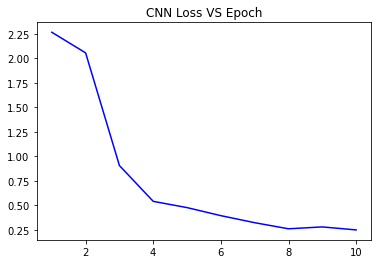

In [ ]:
#plot
plt.plot(train_epoch3_Op,train_losses3_Op,color="blue")
plt.title('CNN Loss VS Epoch')
plt.show()

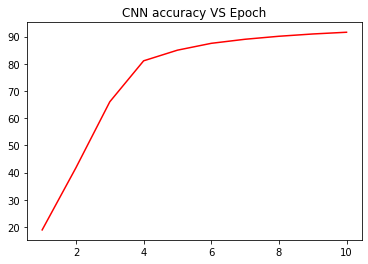

In [ ]:
#plot
plt.plot(train_epoch3_Op,train_acc3_Op,color="red")
plt.title('CNN accuracy VS Epoch')
plt.show()

In [ ]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for test_images, test_labels in test_loader:
        outputs = cnn3_Op(test_images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += test_labels.size(0)
        n_correct += (predicted == test_labels).sum().item()
        
        for i in range(100):
            label = test_labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    netTest_acc3 = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {netTest_acc3} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {i}: {acc} %')

Accuracy of the network: 92.71 %
Accuracy of 0: 98.06122448979592 %
Accuracy of 1: 98.14977973568281 %
Accuracy of 2: 90.79457364341086 %
Accuracy of 3: 93.36633663366337 %
Accuracy of 4: 92.36252545824847 %
Accuracy of 5: 89.01345291479821 %
Accuracy of 6: 94.78079331941545 %
Accuracy of 7: 91.73151750972762 %
Accuracy of 8: 91.9917864476386 %
Accuracy of 9: 86.02576808721507 %
